# 付録A7: 情報カスケードと社会的伝染

このノートブックでは、ネットワーク上での情報や行動の拡散現象である「情報カスケード」と「社会的伝染」について学びます。

## 学習目標

- 情報カスケードと社会的伝染の基本概念を理解する
- 独立カスケードモデル（IC）を実装・シミュレーションする
- 線形閾値モデル（LT）を実装・シミュレーションする
- SIR/SISモデルによる感染症拡散をシミュレーションする
- ネットワーク構造が拡散に与える影響を分析する
- 影響力最大化問題の基礎を学ぶ

## セットアップ

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
from collections import defaultdict
import random

plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)
random.seed(42)

## 1. 情報カスケードと社会的伝染とは

### 1.1 基本概念

**情報カスケード（Information Cascade）** は、個人が他者の行動を観察し、その観察に基づいて自らの行動を決定する連鎖的なプロセスです。

**社会的伝染（Social Contagion）** は、行動、アイデア、感情がネットワークを通じて人から人へと広がる現象を指します。

### 1.2 現実世界での例

- **バイラルマーケティング**: 商品の口コミがSNSで拡散
- **流行の伝播**: ファッション、音楽、ミームの流行
- **技術採用**: 新技術やアプリの普及
- **デマ・フェイクニュース**: 誤情報の拡散
- **感染症**: 病気の伝播（SIR/SISモデル）

### 1.3 伝染モデルの分類

| モデル | 特徴 | 適用例 |
|--------|------|--------|
| 独立カスケード（IC） | 確率的な伝播、各エッジで独立 | 口コミ、バイラル動画 |
| 線形閾値（LT） | 閾値を超えると採用 | 技術採用、社会運動 |
| SIR | 感染→回復（免疫獲得） | 感染症、一過性の流行 |
| SIS | 感染→回復→再感染可能 | 風邪、繰り返すトレンド |

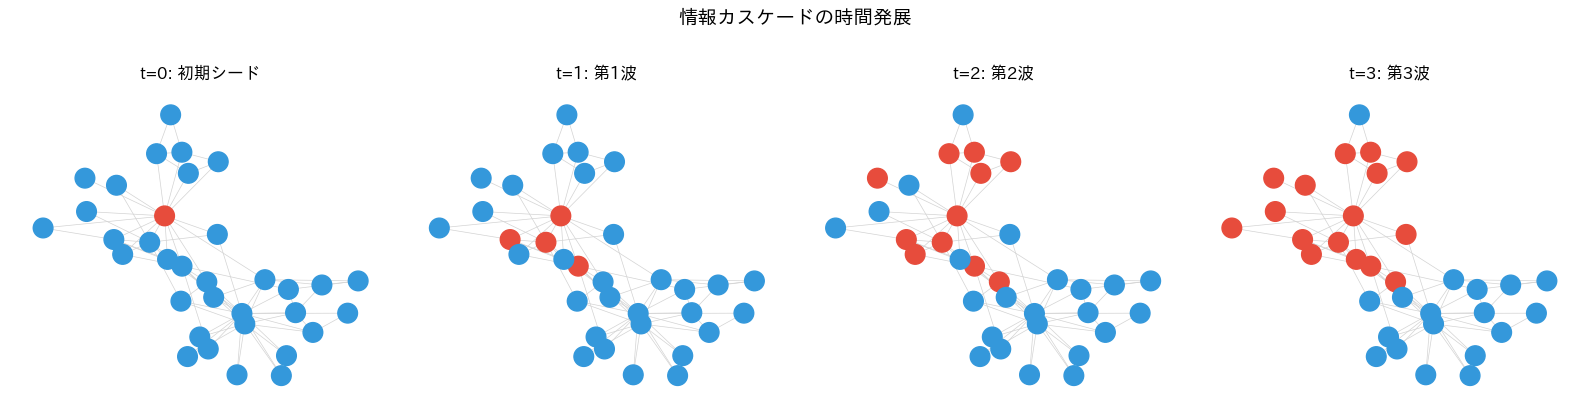

カスケードの拡大: 1人 → 16人


In [2]:
# カスケードの概念図を作成
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# サンプルネットワーク
G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=42)

# 時系列でのカスケード拡散を可視化
cascade_steps = [
    {0},  # 初期シード
    {0, 1, 2, 3},  # ステップ1
    {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11},  # ステップ2
    {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21}  # ステップ3
]

titles = ['t=0: 初期シード', 't=1: 第1波', 't=2: 第2波', 't=3: 第3波']

for ax, infected, title in zip(axes, cascade_steps, titles):
    colors = ['#e74c3c' if n in infected else '#3498db' for n in G.nodes()]
    nx.draw(G, pos, ax=ax, node_color=colors, node_size=200,
            with_labels=False, edge_color='lightgray', width=0.5)
    ax.set_title(title, fontsize=12)

plt.suptitle('情報カスケードの時間発展', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"カスケードの拡大: {len(cascade_steps[0])}人 → {len(cascade_steps[-1])}人")

## 2. 独立カスケードモデル（Independent Cascade Model）

### 2.1 モデルの定義

独立カスケードモデル（ICモデル）は、Kempe et al. (2003) によって提案された確率的な情報拡散モデルです。

**アルゴリズム:**
1. 初期の「活性化」ノード（シード）を選択
2. 各タイムステップで、新たに活性化したノードは各隣接ノードを確率 $p$ で活性化を試みる
3. 各試行は1回のみ（失敗しても再試行なし）
4. 新たな活性化がなくなるまで繰り返す

**特徴:**
- 各エッジでの伝播は独立
- 一度活性化したノードは変化しない（「採用」は取り消せない）
- 確率的なプロセス

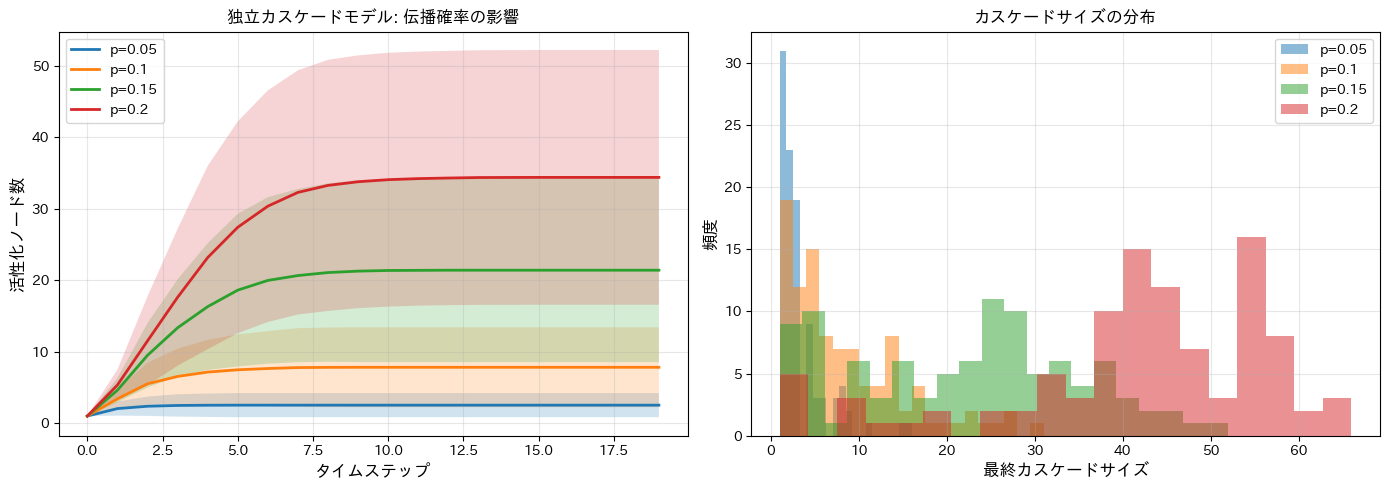

In [3]:
def independent_cascade(G, seeds, p=0.1, max_steps=100):
    """
    独立カスケードモデルのシミュレーション
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    seeds : set
        初期活性化ノードの集合
    p : float
        伝播確率
    max_steps : int
        最大ステップ数
    
    Returns:
    --------
    history : list of sets
        各ステップでの活性化ノード集合
    """
    activated = set(seeds)
    newly_activated = set(seeds)
    history = [activated.copy()]
    
    for step in range(max_steps):
        if not newly_activated:
            break
            
        next_activated = set()
        
        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # 確率pで伝播を試みる
                    if random.random() < p:
                        next_activated.add(neighbor)
        
        activated.update(next_activated)
        newly_activated = next_activated
        history.append(activated.copy())
    
    return history

# シミュレーション実行
G = nx.barabasi_albert_graph(100, 3, seed=42)
seeds = {0}  # ノード0をシードに

# 複数回シミュレーションして平均を取る
n_simulations = 100
p_values = [0.05, 0.1, 0.15, 0.2]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 伝播確率ごとのカスケードサイズ推移
ax1 = axes[0]
for p in p_values:
    all_histories = []
    for _ in range(n_simulations):
        history = independent_cascade(G, seeds, p=p)
        sizes = [len(h) for h in history]
        # 長さを揃える
        while len(sizes) < 20:
            sizes.append(sizes[-1])
        all_histories.append(sizes[:20])
    
    mean_sizes = np.mean(all_histories, axis=0)
    std_sizes = np.std(all_histories, axis=0)
    
    ax1.plot(mean_sizes, label=f'p={p}', linewidth=2)
    ax1.fill_between(range(len(mean_sizes)), 
                     mean_sizes - std_sizes, 
                     mean_sizes + std_sizes, alpha=0.2)

ax1.set_xlabel('タイムステップ', fontsize=12)
ax1.set_ylabel('活性化ノード数', fontsize=12)
ax1.set_title('独立カスケードモデル: 伝播確率の影響', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: 最終的なカスケードサイズの分布
ax2 = axes[1]
for p in p_values:
    final_sizes = []
    for _ in range(n_simulations):
        history = independent_cascade(G, seeds, p=p)
        final_sizes.append(len(history[-1]))
    
    ax2.hist(final_sizes, bins=20, alpha=0.5, label=f'p={p}')

ax2.set_xlabel('最終カスケードサイズ', fontsize=12)
ax2.set_ylabel('頻度', fontsize=12)
ax2.set_title('カスケードサイズの分布', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 臨界現象とフェーズ遷移

伝播確率 $p$ には**臨界値**が存在し、これを超えると大規模なカスケードが発生します。

理論的には、ランダムグラフにおける臨界確率は次のように近似されます：

$$p_c \approx \frac{1}{\langle k \rangle}$$

ここで $\langle k \rangle$ はネットワークの平均次数です。

平均次数: 5.96
理論的臨界確率: p_c ≈ 0.168


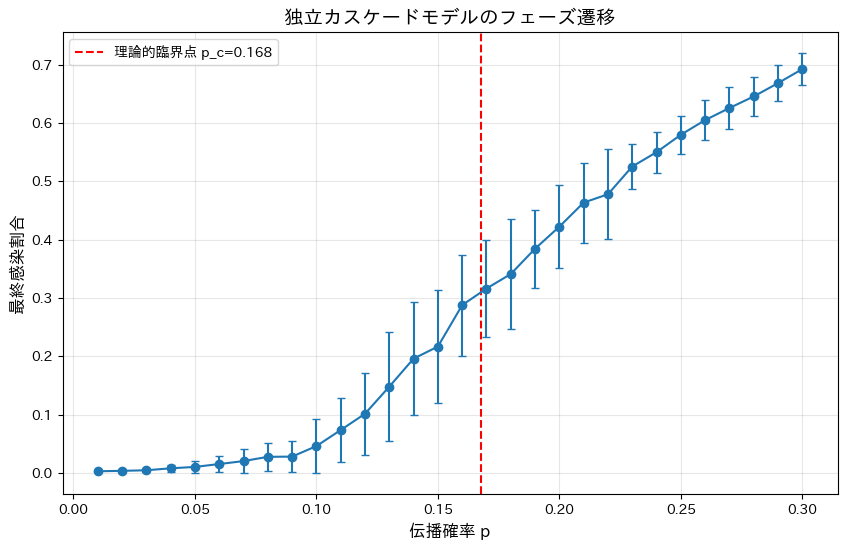

In [4]:
# フェーズ遷移の観察
G = nx.barabasi_albert_graph(500, 3, seed=42)
avg_degree = np.mean([d for n, d in G.degree()])
p_critical = 1 / avg_degree

print(f"平均次数: {avg_degree:.2f}")
print(f"理論的臨界確率: p_c ≈ {p_critical:.3f}")

# 様々な伝播確率でシミュレーション
p_range = np.linspace(0.01, 0.3, 30)
n_simulations = 50

mean_final_sizes = []
std_final_sizes = []

for p in p_range:
    final_sizes = []
    for _ in range(n_simulations):
        history = independent_cascade(G, {0}, p=p)
        final_sizes.append(len(history[-1]) / len(G))  # 割合で正規化
    mean_final_sizes.append(np.mean(final_sizes))
    std_final_sizes.append(np.std(final_sizes))

plt.figure(figsize=(10, 6))
plt.errorbar(p_range, mean_final_sizes, yerr=std_final_sizes, 
             fmt='o-', capsize=3, capthick=1)
plt.axvline(x=p_critical, color='red', linestyle='--', 
            label=f'理論的臨界点 p_c={p_critical:.3f}')
plt.xlabel('伝播確率 p', fontsize=12)
plt.ylabel('最終感染割合', fontsize=12)
plt.title('独立カスケードモデルのフェーズ遷移', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. 線形閾値モデル（Linear Threshold Model）

### 3.1 モデルの定義

線形閾値モデル（LTモデル）は、Mark Granovetter (1978) の閾値モデルを一般化したものです。

**アルゴリズム:**
1. 各ノード $v$ に閾値 $\theta_v \in [0, 1]$ をランダムに割り当て
2. 各エッジ $(u, v)$ に重み $w_{uv}$ を設定（$\sum_{u \in N(v)} w_{uv} \leq 1$）
3. ノード $v$ は、活性化した隣接ノードからの影響の合計が閾値を超えると活性化：
   $$\sum_{u \in N_{active}(v)} w_{uv} \geq \theta_v$$
4. 変化がなくなるまで繰り返す

**特徴:**
- 決定論的（閾値が決まれば結果は確定）
- 周囲の影響が累積的に作用
- 「みんながやっているから」という社会的圧力をモデル化

/tmp/ipykernel_3605/4053679754.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([ic_sizes, lt_sizes], labels=['IC (p=0.1)', 'LT'])


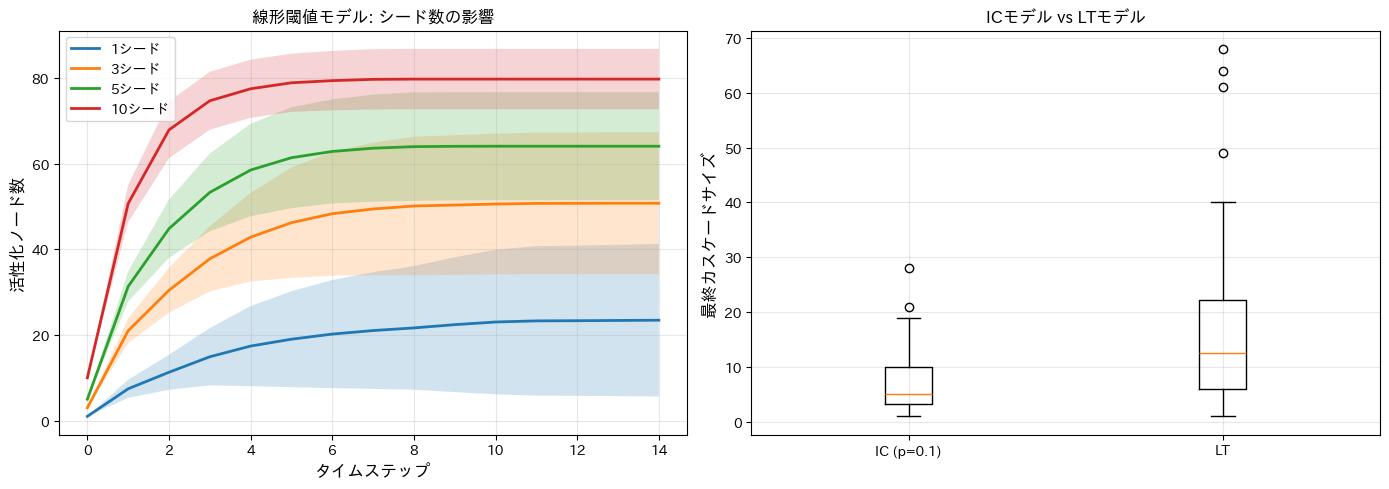

ICモデル平均: 7.3 ± 5.7
LTモデル平均: 17.4 ± 16.5


In [5]:
def linear_threshold(G, seeds, thresholds=None, max_steps=100):
    """
    線形閾値モデルのシミュレーション
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    seeds : set
        初期活性化ノードの集合
    thresholds : dict or None
        各ノードの閾値（Noneの場合はランダムに生成）
    max_steps : int
        最大ステップ数
    
    Returns:
    --------
    history : list of sets
        各ステップでの活性化ノード集合
    """
    # 閾値の設定
    if thresholds is None:
        thresholds = {node: random.random() for node in G.nodes()}
    
    activated = set(seeds)
    history = [activated.copy()]
    
    for step in range(max_steps):
        newly_activated = set()
        
        for node in G.nodes():
            if node in activated:
                continue
            
            # 隣接ノードからの影響を計算
            neighbors = list(G.neighbors(node))
            if not neighbors:
                continue
                
            # 重みは均等（1/次数）
            weight = 1.0 / len(neighbors)
            influence = sum(weight for n in neighbors if n in activated)
            
            if influence >= thresholds[node]:
                newly_activated.add(node)
        
        if not newly_activated:
            break
            
        activated.update(newly_activated)
        history.append(activated.copy())
    
    return history

# シミュレーション実行
G = nx.barabasi_albert_graph(100, 3, seed=42)

# 異なるシード数でのカスケード
seed_counts = [1, 3, 5, 10]
n_simulations = 50

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: シード数ごとのカスケードサイズ推移
ax1 = axes[0]
for n_seeds in seed_counts:
    all_histories = []
    for _ in range(n_simulations):
        # 次数の高いノードをシードに選択
        seeds = set(sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[:n_seeds])
        history = linear_threshold(G, seeds)
        sizes = [len(h) for h in history]
        while len(sizes) < 15:
            sizes.append(sizes[-1])
        all_histories.append(sizes[:15])
    
    mean_sizes = np.mean(all_histories, axis=0)
    std_sizes = np.std(all_histories, axis=0)
    
    ax1.plot(mean_sizes, label=f'{n_seeds}シード', linewidth=2)
    ax1.fill_between(range(len(mean_sizes)), 
                     mean_sizes - std_sizes, 
                     mean_sizes + std_sizes, alpha=0.2)

ax1.set_xlabel('タイムステップ', fontsize=12)
ax1.set_ylabel('活性化ノード数', fontsize=12)
ax1.set_title('線形閾値モデル: シード数の影響', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: ICモデルとLTモデルの比較
ax2 = axes[1]
seeds = {0}

# ICモデル
ic_sizes = []
for _ in range(n_simulations):
    history = independent_cascade(G, seeds, p=0.1)
    ic_sizes.append(len(history[-1]))

# LTモデル
lt_sizes = []
for _ in range(n_simulations):
    history = linear_threshold(G, seeds)
    lt_sizes.append(len(history[-1]))

ax2.boxplot([ic_sizes, lt_sizes], labels=['IC (p=0.1)', 'LT'])
ax2.set_ylabel('最終カスケードサイズ', fontsize=12)
ax2.set_title('ICモデル vs LTモデル', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ICモデル平均: {np.mean(ic_sizes):.1f} ± {np.std(ic_sizes):.1f}")
print(f"LTモデル平均: {np.mean(lt_sizes):.1f} ± {np.std(lt_sizes):.1f}")

### 3.2 閾値分布の影響

閾値の分布によってカスケードの挙動は大きく変わります。

/tmp/ipykernel_3605/4089453254.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(results.values(), labels=results.keys())


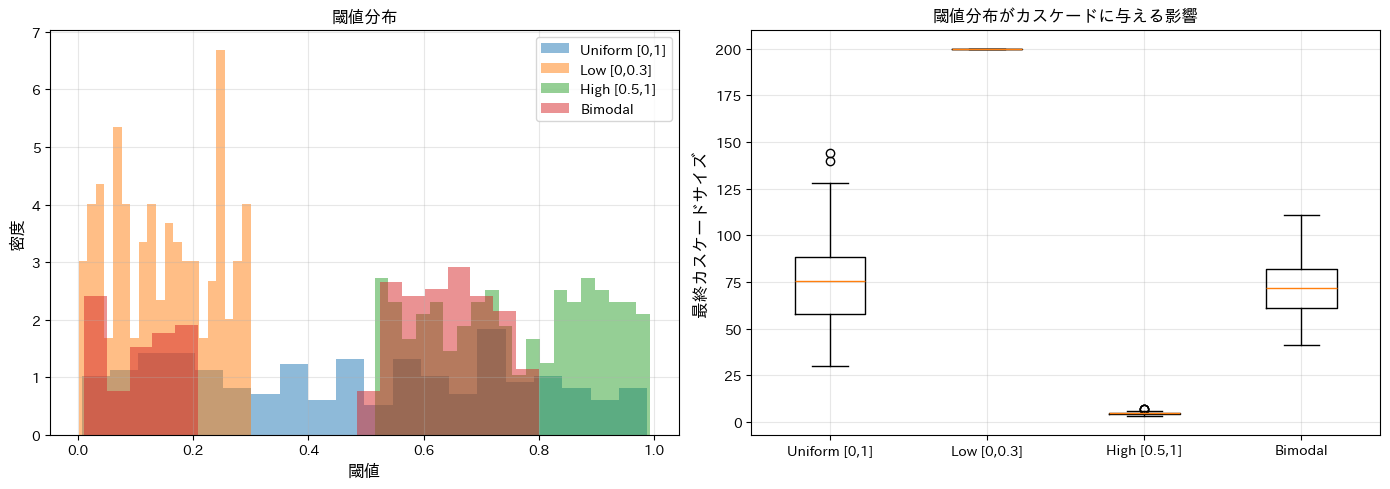

Uniform [0,1]: 平均 76.8 ± 25.3
Low [0,0.3]: 平均 200.0 ± 0.0
High [0.5,1]: 平均 4.9 ± 1.0
Bimodal: 平均 72.7 ± 17.8


In [6]:
# 異なる閾値分布でのシミュレーション
G = nx.barabasi_albert_graph(200, 3, seed=42)

def generate_thresholds(G, distribution='uniform', param=0.5):
    """様々な閾値分布を生成"""
    n = len(G)
    if distribution == 'uniform':
        return {node: random.random() for node in G.nodes()}
    elif distribution == 'low':  # 低い閾値（伝播しやすい）
        return {node: random.uniform(0, param) for node in G.nodes()}
    elif distribution == 'high':  # 高い閾値（伝播しにくい）
        return {node: random.uniform(param, 1) for node in G.nodes()}
    elif distribution == 'bimodal':  # 二峰性（早期採用者と保守派）
        thresholds = {}
        for node in G.nodes():
            if random.random() < 0.3:  # 30%が早期採用者
                thresholds[node] = random.uniform(0, 0.2)
            else:  # 70%が保守派
                thresholds[node] = random.uniform(0.5, 0.8)
        return thresholds

distributions = [
    ('uniform', 'Uniform [0,1]', 0.5),
    ('low', 'Low [0,0.3]', 0.3),
    ('high', 'High [0.5,1]', 0.5),
    ('bimodal', 'Bimodal', 0.5)
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 閾値分布の可視化
ax1 = axes[0]
for dist_type, label, param in distributions:
    thresholds = generate_thresholds(G, dist_type, param)
    values = list(thresholds.values())
    ax1.hist(values, bins=20, alpha=0.5, label=label, density=True)

ax1.set_xlabel('閾値', fontsize=12)
ax1.set_ylabel('密度', fontsize=12)
ax1.set_title('閾値分布', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: カスケードサイズの比較
ax2 = axes[1]
n_simulations = 50
seeds = set(sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[:3])

results = {}
for dist_type, label, param in distributions:
    final_sizes = []
    for _ in range(n_simulations):
        thresholds = generate_thresholds(G, dist_type, param)
        history = linear_threshold(G, seeds, thresholds)
        final_sizes.append(len(history[-1]))
    results[label] = final_sizes

ax2.boxplot(results.values(), labels=results.keys())
ax2.set_ylabel('最終カスケードサイズ', fontsize=12)
ax2.set_title('閾値分布がカスケードに与える影響', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for label, sizes in results.items():
    print(f"{label}: 平均 {np.mean(sizes):.1f} ± {np.std(sizes):.1f}")

## 4. SIR/SISモデル：感染症拡散モデル

### 4.1 SIRモデル

SIRモデルは感染症の拡散をモデル化する古典的な手法で、ネットワーク上での情報拡散にも応用されます。

**状態:**
- **S (Susceptible)**: 感染可能
- **I (Infected)**: 感染中（伝播可能）
- **R (Recovered)**: 回復済み（免疫獲得）

**パラメータ:**
- $\beta$: 感染率（S→Iの確率）
- $\gamma$: 回復率（I→Rの確率）
- $R_0 = \beta / \gamma$: 基本再生産数

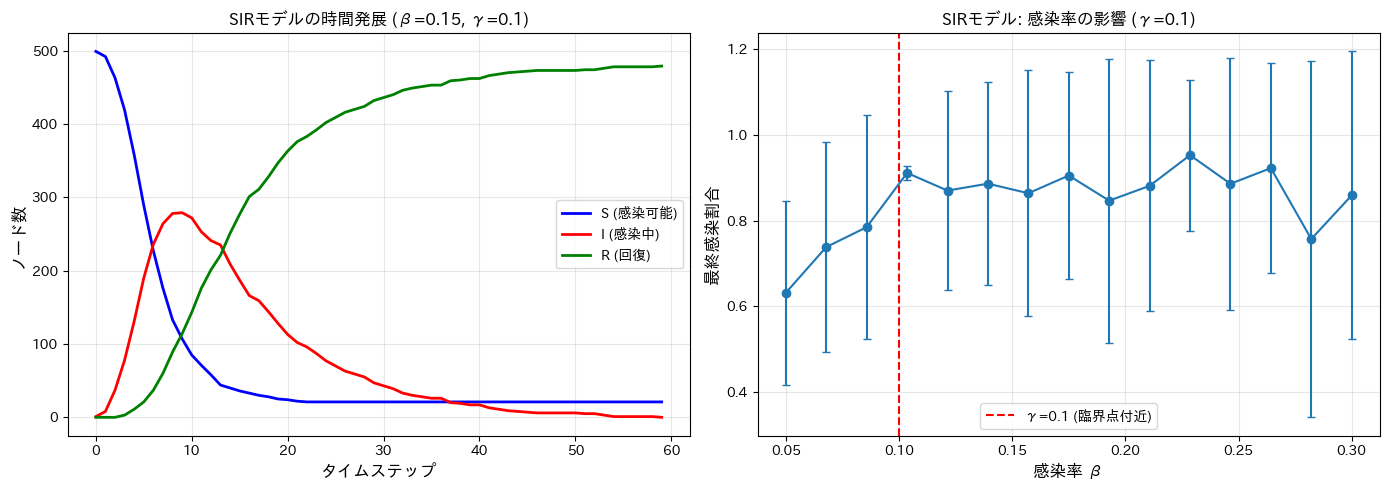

基本再生産数 R0 = β/γ = 1.50
R0 > 1 の場合、感染症は拡大する傾向にある


In [7]:
def sir_model(G, seeds, beta=0.3, gamma=0.1, max_steps=100):
    """
    SIRモデルのシミュレーション
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    seeds : set
        初期感染ノードの集合
    beta : float
        感染率
    gamma : float
        回復率
    max_steps : int
        最大ステップ数
    
    Returns:
    --------
    history : dict
        各ステップでのS, I, Rの数
    """
    # 状態の初期化
    states = {node: 'S' for node in G.nodes()}
    for seed in seeds:
        states[seed] = 'I'
    
    history = {'S': [], 'I': [], 'R': []}
    
    for step in range(max_steps):
        # 現在の状態をカウント
        counts = {'S': 0, 'I': 0, 'R': 0}
        for state in states.values():
            counts[state] += 1
        
        for key in history:
            history[key].append(counts[key])
        
        # 感染者がいなければ終了
        if counts['I'] == 0:
            break
        
        # 状態の更新
        new_states = states.copy()
        
        for node in G.nodes():
            if states[node] == 'I':
                # 回復の試み
                if random.random() < gamma:
                    new_states[node] = 'R'
                else:
                    # 隣接ノードへの感染の試み
                    for neighbor in G.neighbors(node):
                        if states[neighbor] == 'S':
                            if random.random() < beta:
                                new_states[neighbor] = 'I'
        
        states = new_states
    
    return history

# シミュレーション実行
G = nx.barabasi_albert_graph(500, 3, seed=42)
seeds = {0}

# 単一シミュレーションの可視化
history = sir_model(G, seeds, beta=0.15, gamma=0.1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: SIRの時間発展
ax1 = axes[0]
ax1.plot(history['S'], label='S (感染可能)', color='blue', linewidth=2)
ax1.plot(history['I'], label='I (感染中)', color='red', linewidth=2)
ax1.plot(history['R'], label='R (回復)', color='green', linewidth=2)
ax1.set_xlabel('タイムステップ', fontsize=12)
ax1.set_ylabel('ノード数', fontsize=12)
ax1.set_title('SIRモデルの時間発展 (β=0.15, γ=0.1)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: 感染率による最終感染者数
ax2 = axes[1]
beta_values = np.linspace(0.05, 0.3, 15)
gamma = 0.1
n_simulations = 30

mean_infected = []
std_infected = []

for beta in beta_values:
    final_infected = []
    for _ in range(n_simulations):
        history = sir_model(G, seeds, beta=beta, gamma=gamma)
        # 最終的に感染した人数（R）
        final_infected.append(history['R'][-1] / len(G))
    mean_infected.append(np.mean(final_infected))
    std_infected.append(np.std(final_infected))

ax2.errorbar(beta_values, mean_infected, yerr=std_infected, 
             fmt='o-', capsize=3, capthick=1)
ax2.axvline(x=gamma, color='red', linestyle='--', 
            label=f'γ={gamma} (臨界点付近)')
ax2.set_xlabel('感染率 β', fontsize=12)
ax2.set_ylabel('最終感染割合', fontsize=12)
ax2.set_title(f'SIRモデル: 感染率の影響 (γ={gamma})', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

R0 = 0.15 / 0.1
print(f"基本再生産数 R0 = β/γ = {R0:.2f}")
print(f"R0 > 1 の場合、感染症は拡大する傾向にある")

### 4.2 SISモデル

SISモデルでは、回復後に再び感染可能な状態に戻ります（免疫がない）。

**状態遷移:** S → I → S → I → ...

これは風邪のように何度も感染する病気や、繰り返し広まる流行をモデル化します。

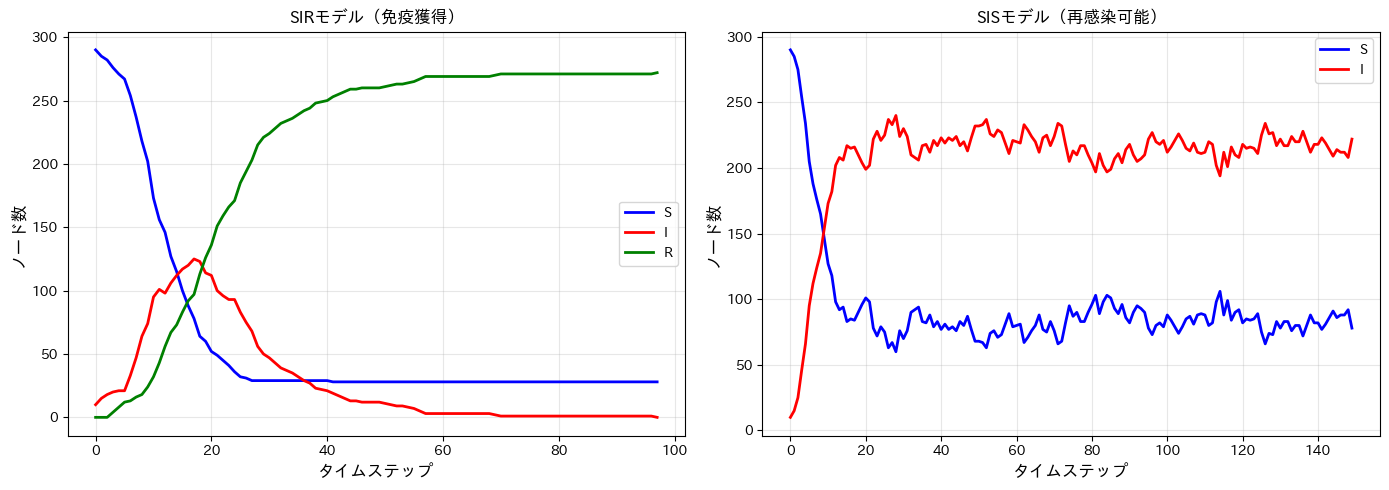

SIRモデル: 感染は収束し、集団免疫が形成される
SISモデル: 感染は定常状態に達し、endemic（風土病的）な状態になりうる


In [8]:
def sis_model(G, seeds, beta=0.3, gamma=0.1, max_steps=200):
    """
    SISモデルのシミュレーション
    """
    states = {node: 'S' for node in G.nodes()}
    for seed in seeds:
        states[seed] = 'I'
    
    history = {'S': [], 'I': []}
    
    for step in range(max_steps):
        counts = {'S': 0, 'I': 0}
        for state in states.values():
            counts[state] += 1
        
        for key in history:
            history[key].append(counts[key])
        
        new_states = states.copy()
        
        for node in G.nodes():
            if states[node] == 'I':
                # 回復（Sに戻る）
                if random.random() < gamma:
                    new_states[node] = 'S'
                else:
                    # 感染の試み
                    for neighbor in G.neighbors(node):
                        if states[neighbor] == 'S':
                            if random.random() < beta:
                                new_states[neighbor] = 'I'
        
        states = new_states
    
    return history

# SIRとSISの比較
G = nx.barabasi_albert_graph(300, 3, seed=42)
seeds = set(random.sample(list(G.nodes()), 10))
beta, gamma = 0.1, 0.1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SIRモデル
ax1 = axes[0]
history_sir = sir_model(G, seeds, beta=beta, gamma=gamma, max_steps=150)
ax1.plot(history_sir['S'], label='S', color='blue', linewidth=2)
ax1.plot(history_sir['I'], label='I', color='red', linewidth=2)
ax1.plot(history_sir['R'], label='R', color='green', linewidth=2)
ax1.set_xlabel('タイムステップ', fontsize=12)
ax1.set_ylabel('ノード数', fontsize=12)
ax1.set_title('SIRモデル（免疫獲得）', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# SISモデル
ax2 = axes[1]
history_sis = sis_model(G, seeds, beta=beta, gamma=gamma, max_steps=150)
ax2.plot(history_sis['S'], label='S', color='blue', linewidth=2)
ax2.plot(history_sis['I'], label='I', color='red', linewidth=2)
ax2.set_xlabel('タイムステップ', fontsize=12)
ax2.set_ylabel('ノード数', fontsize=12)
ax2.set_title('SISモデル（再感染可能）', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("SIRモデル: 感染は収束し、集団免疫が形成される")
print("SISモデル: 感染は定常状態に達し、endemic（風土病的）な状態になりうる")

## 5. ネットワーク構造と拡散の関係

### 5.1 異なるネットワーク構造での比較

ネットワークのトポロジーは情報拡散に大きな影響を与えます。

In [9]:
# 異なるネットワーク構造を生成
n = 200
networks = {
    'ランダム (ER)': nx.erdos_renyi_graph(n, 0.03, seed=42),
    'スケールフリー (BA)': nx.barabasi_albert_graph(n, 3, seed=42),
    'スモールワールド (WS)': nx.watts_strogatz_graph(n, 6, 0.3, seed=42),
    '格子': nx.grid_2d_graph(14, 14)
}

# 格子グラフのノードをリラベル
networks['格子'] = nx.convert_node_labels_to_integers(networks['格子'])

# ネットワーク特性の比較
print("ネットワーク特性の比較:")
print("-" * 60)
print(f"{'ネットワーク':<20} {'ノード':<8} {'エッジ':<8} {'平均次数':<10} {'クラスタ係数':<12}")
print("-" * 60)

for name, G in networks.items():
    avg_degree = np.mean([d for n, d in G.degree()])
    clustering = nx.average_clustering(G)
    print(f"{name:<20} {G.number_of_nodes():<8} {G.number_of_edges():<8} {avg_degree:<10.2f} {clustering:<12.3f}")

ネットワーク特性の比較:
------------------------------------------------------------
ネットワーク               ノード      エッジ      平均次数       クラスタ係数      
------------------------------------------------------------
ランダム (ER)            200      569      5.69       0.039       
スケールフリー (BA)         200      591      5.91       0.102       
スモールワールド (WS)        200      600      6.00       0.215       
格子                   196      364      3.71       0.000       


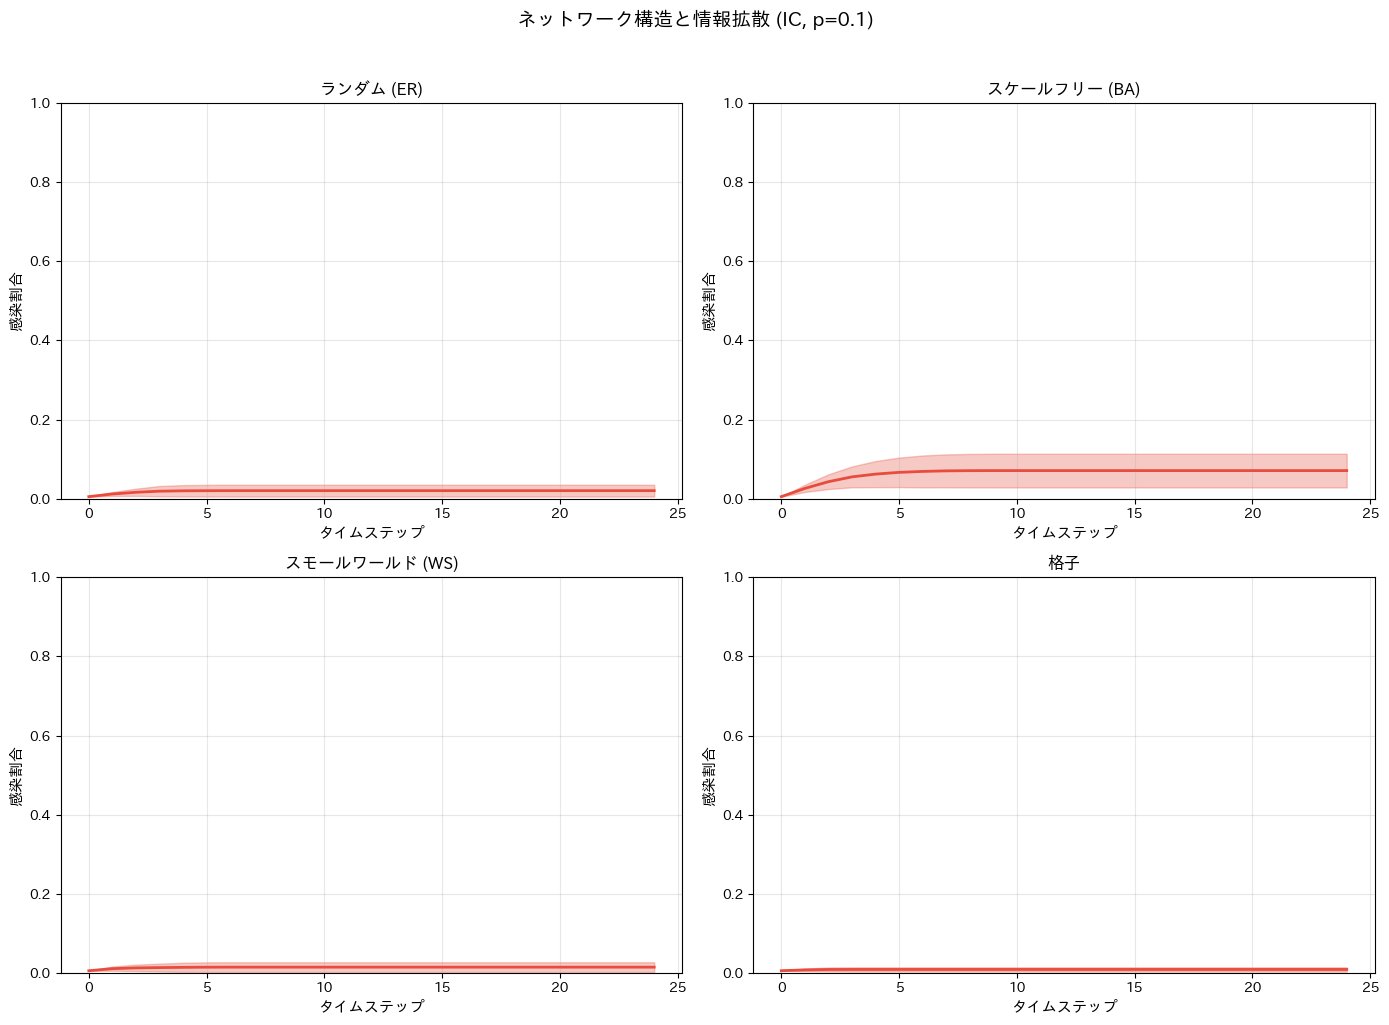


最終感染割合の比較:
----------------------------------------
ランダム (ER)           : 2.0% ± 1.5%
スケールフリー (BA)        : 7.1% ± 4.3%
スモールワールド (WS)       : 1.4% ± 1.2%
格子                  : 0.8% ± 0.5%


In [10]:
# 各ネットワークでのICモデルシミュレーション
n_simulations = 50
p = 0.1

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

results = {}

for idx, (name, G) in enumerate(networks.items()):
    ax = axes[idx]
    
    # ハブノードをシードに
    hub = max(G.nodes(), key=lambda x: G.degree(x))
    seeds = {hub}
    
    all_histories = []
    final_sizes = []
    
    for _ in range(n_simulations):
        history = independent_cascade(G, seeds, p=p)
        sizes = [len(h) / len(G) for h in history]  # 正規化
        while len(sizes) < 25:
            sizes.append(sizes[-1])
        all_histories.append(sizes[:25])
        final_sizes.append(sizes[-1])
    
    results[name] = final_sizes
    
    mean_sizes = np.mean(all_histories, axis=0)
    std_sizes = np.std(all_histories, axis=0)
    
    ax.plot(mean_sizes, linewidth=2, color='#e74c3c')
    ax.fill_between(range(len(mean_sizes)), 
                    mean_sizes - std_sizes, 
                    mean_sizes + std_sizes, alpha=0.3, color='#e74c3c')
    ax.set_xlabel('タイムステップ', fontsize=11)
    ax.set_ylabel('感染割合', fontsize=11)
    ax.set_title(f'{name}', fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'ネットワーク構造と情報拡散 (IC, p={p})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# 結果のサマリー
print("\n最終感染割合の比較:")
print("-" * 40)
for name, sizes in results.items():
    print(f"{name:<20}: {np.mean(sizes)*100:.1f}% ± {np.std(sizes)*100:.1f}%")

### 5.2 次数分布と拡散速度

スケールフリーネットワークのハブは、情報拡散において特に重要な役割を果たします。

/tmp/ipykernel_3605/455092621.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(final_results.values(), labels=final_results.keys(), patch_artist=True)


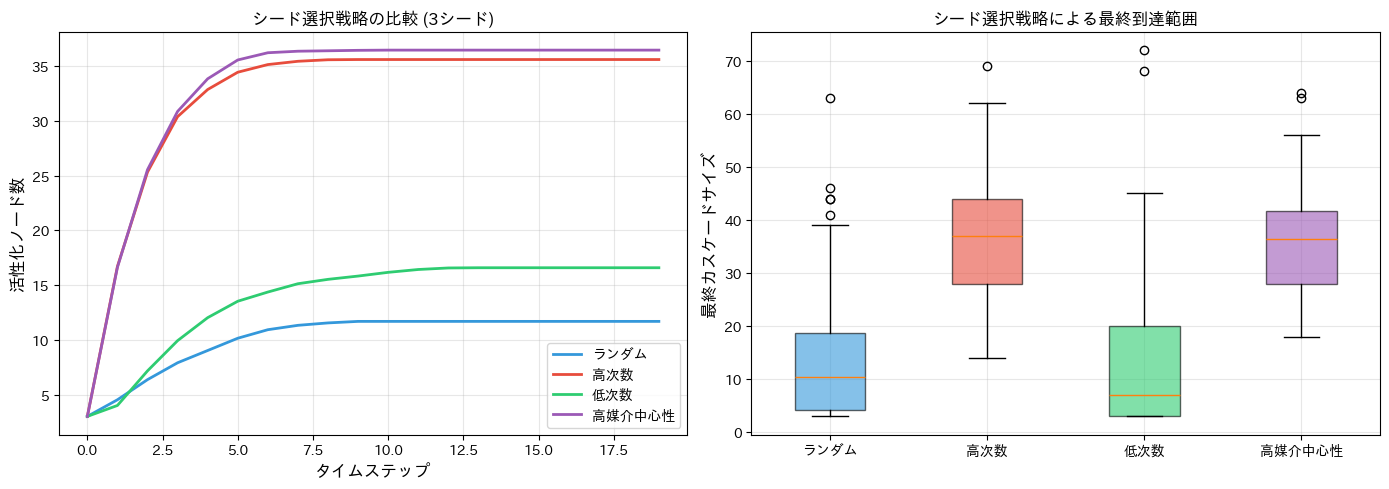


各戦略の効果:
ランダム           : 平均 15.4 ± 14.4
高次数            : 平均 36.8 ± 12.4
低次数            : 平均 14.7 ± 15.9
高媒介中心性         : 平均 36.7 ± 10.8


In [11]:
# スケールフリーネットワークでのシード選択戦略の比較
G = nx.barabasi_albert_graph(300, 3, seed=42)

def select_seeds(G, strategy, n_seeds=5):
    """異なる戦略でシードを選択"""
    if strategy == 'random':
        return set(random.sample(list(G.nodes()), n_seeds))
    elif strategy == 'high_degree':
        return set(sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[:n_seeds])
    elif strategy == 'low_degree':
        return set(sorted(G.nodes(), key=lambda x: G.degree(x))[:n_seeds])
    elif strategy == 'high_betweenness':
        bc = nx.betweenness_centrality(G)
        return set(sorted(bc.keys(), key=lambda x: bc[x], reverse=True)[:n_seeds])

strategies = ['random', 'high_degree', 'low_degree', 'high_betweenness']
strategy_names = ['ランダム', '高次数', '低次数', '高媒介中心性']
n_simulations = 50
n_seeds = 3

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: カスケードの時間発展
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

for strategy, name, color in zip(strategies, strategy_names, colors):
    all_histories = []
    for _ in range(n_simulations):
        seeds = select_seeds(G, strategy, n_seeds)
        history = independent_cascade(G, seeds, p=0.1)
        sizes = [len(h) for h in history]
        while len(sizes) < 20:
            sizes.append(sizes[-1])
        all_histories.append(sizes[:20])
    
    mean_sizes = np.mean(all_histories, axis=0)
    ax1.plot(mean_sizes, label=name, linewidth=2, color=color)

ax1.set_xlabel('タイムステップ', fontsize=12)
ax1.set_ylabel('活性化ノード数', fontsize=12)
ax1.set_title(f'シード選択戦略の比較 ({n_seeds}シード)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: 最終カスケードサイズの箱ひげ図
ax2 = axes[1]
final_results = {}

for strategy, name in zip(strategies, strategy_names):
    final_sizes = []
    for _ in range(n_simulations):
        seeds = select_seeds(G, strategy, n_seeds)
        history = independent_cascade(G, seeds, p=0.1)
        final_sizes.append(len(history[-1]))
    final_results[name] = final_sizes

bp = ax2.boxplot(final_results.values(), labels=final_results.keys(), patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('最終カスケードサイズ', fontsize=12)
ax2.set_title('シード選択戦略による最終到達範囲', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n各戦略の効果:")
for name, sizes in final_results.items():
    print(f"{name:<15}: 平均 {np.mean(sizes):.1f} ± {np.std(sizes):.1f}")

## 6. 影響力最大化問題

### 6.1 問題の定義

**影響力最大化問題（Influence Maximization）** は、限られた数のシードノードを選択して、カスケードの期待到達範囲を最大化する問題です。

$$\max_{S \subseteq V, |S| = k} \sigma(S)$$

ここで $\sigma(S)$ はシード集合 $S$ から始まるカスケードの期待到達ノード数です。

この問題はNP困難ですが、$\sigma(S)$ が劣モジュラ関数であるため、貪欲法で $(1 - 1/e)$ 近似が保証されます。

### 6.2 貪欲アルゴリズム

In [12]:
def estimate_spread(G, seeds, model='IC', p=0.1, n_simulations=100):
    """
    シード集合からの期待拡散範囲を推定
    """
    spreads = []
    for _ in range(n_simulations):
        if model == 'IC':
            history = independent_cascade(G, seeds, p=p)
        else:
            history = linear_threshold(G, seeds)
        spreads.append(len(history[-1]))
    return np.mean(spreads)

def greedy_influence_maximization(G, k, model='IC', p=0.1, n_simulations=50):
    """
    貪欲法による影響力最大化
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    k : int
        選択するシード数
    model : str
        'IC' または 'LT'
    p : float
        ICモデルの伝播確率
    n_simulations : int
        拡散推定のシミュレーション回数
    
    Returns:
    --------
    seeds : list
        選択されたシードノード
    spreads : list
        各ステップでの拡散範囲
    """
    seeds = []
    spreads = [0]
    candidates = set(G.nodes())
    
    for i in range(k):
        best_node = None
        best_marginal = -1
        
        for node in candidates:
            current_seeds = set(seeds) | {node}
            spread = estimate_spread(G, current_seeds, model, p, n_simulations)
            marginal = spread - spreads[-1]
            
            if marginal > best_marginal:
                best_marginal = marginal
                best_node = node
        
        seeds.append(best_node)
        candidates.remove(best_node)
        spreads.append(spreads[-1] + best_marginal)
        print(f"  シード {i+1}: ノード {best_node} (次数={G.degree(best_node)}, 限界利得={best_marginal:.1f})")
    
    return seeds, spreads[1:]

# 小規模ネットワークでデモ
G = nx.barabasi_albert_graph(100, 3, seed=42)
k = 5

print("貪欲法による影響力最大化:")
print("-" * 50)
greedy_seeds, greedy_spreads = greedy_influence_maximization(G, k, model='IC', p=0.1, n_simulations=30)

貪欲法による影響力最大化:
--------------------------------------------------
  シード 1: ノード 4 (次数=30, 限界利得=10.0)
  シード 2: ノード 7 (次数=23, 限界利得=3.7)
  シード 3: ノード 6 (次数=26, 限界利得=4.4)
  シード 4: ノード 81 (次数=4, 限界利得=3.0)
  シード 5: ノード 35 (次数=3, 限界利得=1.5)


各戦略の性能評価:
--------------------------------------------------

貪欲法:
  シード 1: ノード 6 (次数=26, 限界利得=9.1)
  シード 2: ノード 33 (次数=4, 限界利得=5.7)
  シード 3: ノード 8 (次数=13, 限界利得=3.0)
  シード 4: ノード 4 (次数=30, 限界利得=4.1)


  シード 5: ノード 3 (次数=19, 限界利得=1.3)
  シード: [6, 33, 8, 4, 3]
  平均拡散: 21.1 ± 5.7

次数中心性:
  シード: [4, 5, 6, 0, 7]
  平均拡散: 21.7 ± 5.5

媒介中心性:


  シード: [4, 6, 5, 0, 3]
  平均拡散: 20.9 ± 5.4

ランダム:
  シード: [58, 92, 0, 9, 75]
  平均拡散: 16.4 ± 6.9


/tmp/ipykernel_3605/2794916520.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(results.values(), labels=results.keys(), patch_artist=True)


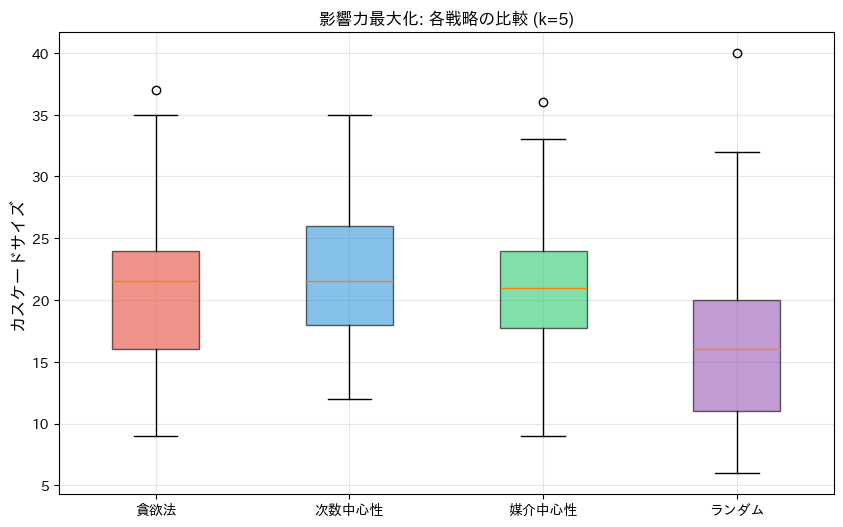

In [13]:
# 様々な戦略との比較
def get_seeds_by_strategy(G, k, strategy):
    if strategy == 'greedy':
        seeds, _ = greedy_influence_maximization(G, k, model='IC', p=0.1, n_simulations=20)
        return seeds
    elif strategy == 'degree':
        return list(sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[:k])
    elif strategy == 'betweenness':
        bc = nx.betweenness_centrality(G)
        return list(sorted(bc.keys(), key=lambda x: bc[x], reverse=True)[:k])
    elif strategy == 'random':
        return random.sample(list(G.nodes()), k)

G = nx.barabasi_albert_graph(100, 3, seed=42)
k = 5
n_eval = 100

strategies = {
    '貪欲法': 'greedy',
    '次数中心性': 'degree', 
    '媒介中心性': 'betweenness',
    'ランダム': 'random'
}

print("各戦略の性能評価:")
print("-" * 50)

results = {}
for name, strategy in strategies.items():
    print(f"\n{name}:")
    seeds = get_seeds_by_strategy(G, k, strategy)
    
    # 複数回評価
    spreads = []
    for _ in range(n_eval):
        history = independent_cascade(G, set(seeds), p=0.1)
        spreads.append(len(history[-1]))
    
    results[name] = spreads
    print(f"  シード: {seeds}")
    print(f"  平均拡散: {np.mean(spreads):.1f} ± {np.std(spreads):.1f}")

# 可視化
fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(results.values(), labels=results.keys(), patch_artist=True)
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('カスケードサイズ', fontsize=12)
ax.set_title(f'影響力最大化: 各戦略の比較 (k={k})', fontsize=12)
ax.grid(True, alpha=0.3)
plt.show()

## 7. カスケード可視化

情報拡散の過程をアニメーション的に可視化します。

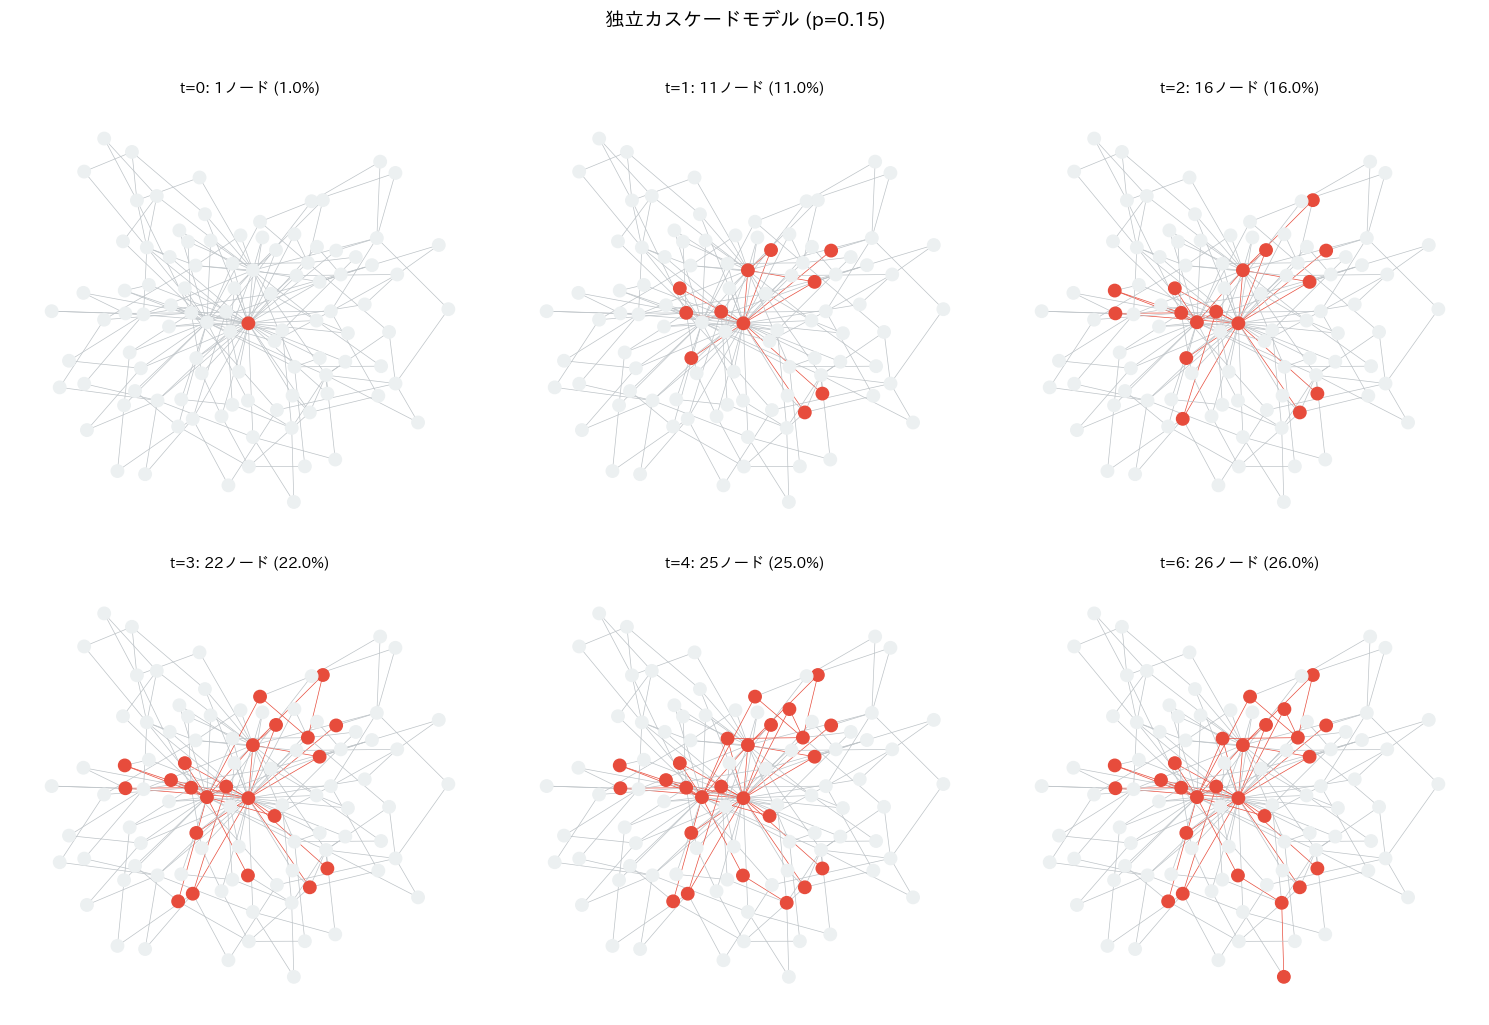

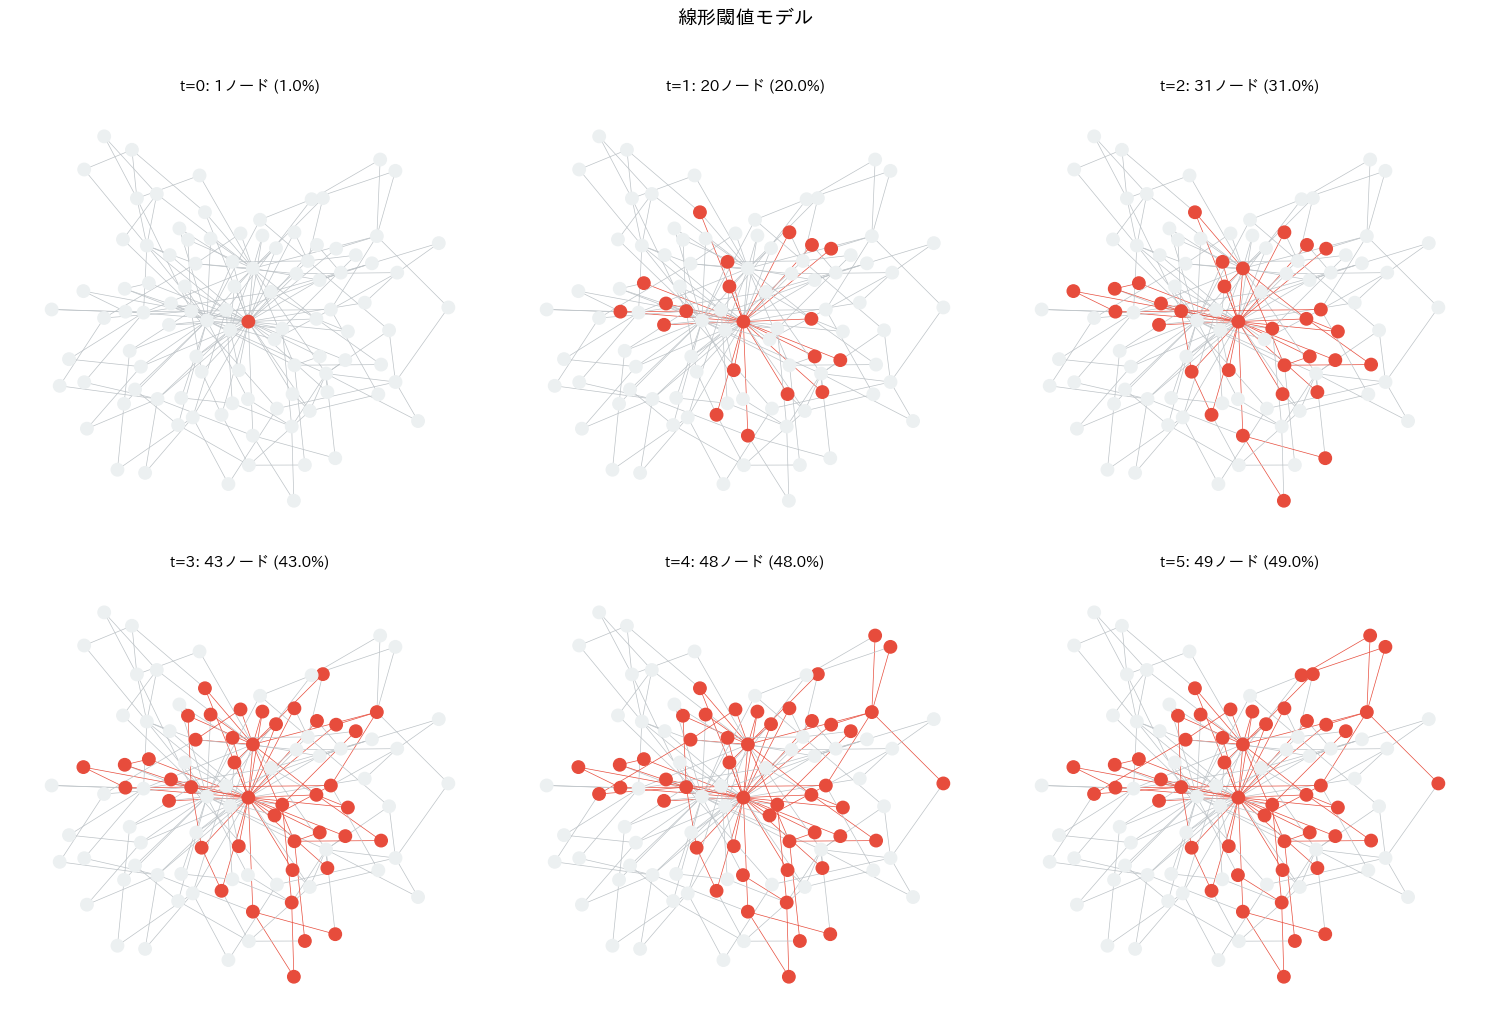

In [14]:
def visualize_cascade(G, history, title="情報カスケードの拡散"):
    """
    カスケードの時間発展を可視化
    """
    n_steps = min(6, len(history))
    step_indices = np.linspace(0, len(history)-1, n_steps, dtype=int)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    pos = nx.spring_layout(G, seed=42)
    
    for idx, (ax, step_idx) in enumerate(zip(axes, step_indices)):
        activated = history[step_idx]
        
        # ノードの色
        colors = ['#e74c3c' if n in activated else '#ecf0f1' for n in G.nodes()]
        
        # エッジの色
        edge_colors = []
        for u, v in G.edges():
            if u in activated and v in activated:
                edge_colors.append('#e74c3c')
            else:
                edge_colors.append('#bdc3c7')
        
        nx.draw(G, pos, ax=ax, node_color=colors, edge_color=edge_colors,
                node_size=80, width=0.5, with_labels=False)
        
        ax.set_title(f't={step_idx}: {len(activated)}ノード ({len(activated)/len(G)*100:.1f}%)', fontsize=11)
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# カスケードの可視化
G = nx.barabasi_albert_graph(100, 2, seed=42)

# ハブノードからスタート
hub = max(G.nodes(), key=lambda x: G.degree(x))
seeds = {hub}

# ICモデル
random.seed(123)
history_ic = independent_cascade(G, seeds, p=0.15)
visualize_cascade(G, history_ic, "独立カスケードモデル (p=0.15)")

# LTモデル
random.seed(123)
history_lt = linear_threshold(G, seeds)
visualize_cascade(G, history_lt, "線形閾値モデル")

## 8. まとめ

このノートブックでは、情報カスケードと社会的伝染の主要なモデルについて学びました。

### 主要な概念

| モデル | 特徴 | 適用場面 |
|--------|------|----------|
| 独立カスケード (IC) | 確率的伝播、各エッジで独立に試行 | バイラルマーケティング、口コミ |
| 線形閾値 (LT) | 累積的影響、閾値超えで採用 | 技術採用、社会運動 |
| SIR | 感染→回復（免疫） | 感染症、一過性のトレンド |
| SIS | 感染→回復→再感染 | 風邪、繰り返す流行 |

### 重要なポイント

1. **臨界現象**: 伝播確率には臨界値があり、これを超えると大規模カスケードが発生
2. **ネットワーク構造の影響**: スケールフリーネットワークはハブを通じて急速に拡散
3. **シード選択**: 高次数ノードや高媒介中心性ノードからの拡散が効果的
4. **影響力最大化**: 貪欲法で近似最適解が得られる（劣モジュラ性）

### 実務への応用

- マーケティング: インフルエンサーの特定
- 公衆衛生: ワクチン接種の優先順位
- フェイクニュース対策: 拡散経路の遮断
- 製品普及: アーリーアダプターの獲得戦略

---

## 練習問題

### 問題1: カスケードの比較分析

100ノードのWatts-Strogatzグラフ（k=4, p=0.3）を作成し、ICモデル（伝播確率0.15）とLTモデルでカスケードを比較してください。各モデルで100回シミュレーションを行い、最終カスケードサイズの分布をヒストグラムで可視化してください。

<details>
<summary>解答例</summary>

```python
# Watts-Strogatzグラフの作成
G = nx.watts_strogatz_graph(100, 4, 0.3, seed=42)

# シードはハブノード
hub = max(G.nodes(), key=lambda x: G.degree(x))
seeds = {hub}

n_simulations = 100

# ICモデル
ic_final_sizes = []
for _ in range(n_simulations):
    history = independent_cascade(G, seeds, p=0.15)
    ic_final_sizes.append(len(history[-1]))

# LTモデル
lt_final_sizes = []
for _ in range(n_simulations):
    history = linear_threshold(G, seeds)
    lt_final_sizes.append(len(history[-1]))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(ic_final_sizes, bins=20, alpha=0.7, color='#3498db', edgecolor='black')
axes[0].axvline(np.mean(ic_final_sizes), color='red', linestyle='--', label=f'平均={np.mean(ic_final_sizes):.1f}')
axes[0].set_xlabel('カスケードサイズ')
axes[0].set_ylabel('頻度')
axes[0].set_title('ICモデル (p=0.15)')
axes[0].legend()

axes[1].hist(lt_final_sizes, bins=20, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[1].axvline(np.mean(lt_final_sizes), color='blue', linestyle='--', label=f'平均={np.mean(lt_final_sizes):.1f}')
axes[1].set_xlabel('カスケードサイズ')
axes[1].set_ylabel('頻度')
axes[1].set_title('LTモデル')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"ICモデル: 平均 {np.mean(ic_final_sizes):.1f} ± {np.std(ic_final_sizes):.1f}")
print(f"LTモデル: 平均 {np.mean(lt_final_sizes):.1f} ± {np.std(lt_final_sizes):.1f}")
```

</details>

### 問題2: SIRモデルでのワクチン接種戦略

200ノードのスケールフリーネットワークで、以下のワクチン接種戦略を比較してください：
1. ランダムに20%のノードにワクチン接種（感染しない）
2. 次数の高い上位20%のノードにワクチン接種

SIRモデル（β=0.15, γ=0.1）で50回シミュレーションし、最終感染者数を比較してください。

<details>
<summary>解答例</summary>

```python
def sir_with_vaccination(G, seeds, vaccinated, beta=0.15, gamma=0.1, max_steps=100):
    """ワクチン接種を考慮したSIRモデル"""
    states = {node: 'S' for node in G.nodes()}
    
    # ワクチン接種済みノードはRとして扱う（感染しない）
    for v in vaccinated:
        states[v] = 'R'
    
    # 初期感染者（ワクチン未接種の場合のみ）
    for seed in seeds:
        if states[seed] == 'S':
            states[seed] = 'I'
    
    total_infected = sum(1 for s in states.values() if s == 'I')
    
    for step in range(max_steps):
        infected_count = sum(1 for s in states.values() if s == 'I')
        if infected_count == 0:
            break
        
        new_states = states.copy()
        
        for node in G.nodes():
            if states[node] == 'I':
                if random.random() < gamma:
                    new_states[node] = 'R'
                    total_infected += 1  # 回復時にカウント
                else:
                    for neighbor in G.neighbors(node):
                        if states[neighbor] == 'S':
                            if random.random() < beta:
                                new_states[neighbor] = 'I'
        
        states = new_states
    
    # 最終的に感染した人数（ワクチン接種者を除く）
    final_recovered = sum(1 for n, s in states.items() if s == 'R' and n not in vaccinated)
    return final_recovered

# ネットワーク作成
G = nx.barabasi_albert_graph(200, 3, seed=42)
n_vaccinate = int(0.2 * len(G))  # 20%
n_simulations = 50

# 初期感染者はランダム
initial_infected = {0}

# 戦略1: ランダムワクチン接種
random_results = []
for _ in range(n_simulations):
    vaccinated = set(random.sample(list(G.nodes()), n_vaccinate))
    infected = sir_with_vaccination(G, initial_infected, vaccinated)
    random_results.append(infected)

# 戦略2: 高次数ノードへのワクチン接種
high_degree_nodes = set(sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)[:n_vaccinate])
targeted_results = []
for _ in range(n_simulations):
    infected = sir_with_vaccination(G, initial_infected, high_degree_nodes)
    targeted_results.append(infected)

# 可視化
fig, ax = plt.subplots(figsize=(8, 5))
bp = ax.boxplot([random_results, targeted_results], 
                labels=['ランダム接種', '高次数優先接種'], 
                patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')

ax.set_ylabel('最終感染者数')
ax.set_title('ワクチン接種戦略の比較 (20%接種)')
ax.grid(True, alpha=0.3)
plt.show()

print(f"ランダム接種: 平均 {np.mean(random_results):.1f} ± {np.std(random_results):.1f}")
print(f"高次数優先接種: 平均 {np.mean(targeted_results):.1f} ± {np.std(targeted_results):.1f}")
print(f"\n高次数優先接種により感染者数を {(1 - np.mean(targeted_results)/np.mean(random_results))*100:.1f}% 削減")
```

</details>

### 問題3: 複数シードの影響力最大化

150ノードのスケールフリーネットワークで、シード数を1から10まで変化させたときの期待カスケードサイズを、次の3つの戦略で比較してください：
1. 次数中心性上位k個
2. 媒介中心性上位k個  
3. ランダムにk個

各設定で30回シミュレーションし、結果を折れ線グラフで可視化してください。

<details>
<summary>解答例</summary>

```python
G = nx.barabasi_albert_graph(150, 3, seed=42)

# 中心性の事前計算
betweenness = nx.betweenness_centrality(G)
degree_ranking = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)
betweenness_ranking = sorted(betweenness.keys(), key=lambda x: betweenness[x], reverse=True)

k_values = range(1, 11)
n_simulations = 30
p = 0.1

results = {
    '次数中心性': [],
    '媒介中心性': [],
    'ランダム': []
}

for k in k_values:
    # 次数中心性
    seeds_degree = set(degree_ranking[:k])
    spreads = [len(independent_cascade(G, seeds_degree, p=p)[-1]) for _ in range(n_simulations)]
    results['次数中心性'].append((np.mean(spreads), np.std(spreads)))
    
    # 媒介中心性
    seeds_betweenness = set(betweenness_ranking[:k])
    spreads = [len(independent_cascade(G, seeds_betweenness, p=p)[-1]) for _ in range(n_simulations)]
    results['媒介中心性'].append((np.mean(spreads), np.std(spreads)))
    
    # ランダム
    spreads = []
    for _ in range(n_simulations):
        seeds_random = set(random.sample(list(G.nodes()), k))
        spreads.append(len(independent_cascade(G, seeds_random, p=p)[-1]))
    results['ランダム'].append((np.mean(spreads), np.std(spreads)))

# 可視化
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'次数中心性': '#e74c3c', '媒介中心性': '#3498db', 'ランダム': '#2ecc71'}

for name, data in results.items():
    means = [d[0] for d in data]
    stds = [d[1] for d in data]
    ax.plot(k_values, means, 'o-', label=name, color=colors[name], linewidth=2)
    ax.fill_between(k_values, 
                    [m-s for m,s in zip(means, stds)],
                    [m+s for m,s in zip(means, stds)],
                    alpha=0.2, color=colors[name])

ax.set_xlabel('シード数 k', fontsize=12)
ax.set_ylabel('期待カスケードサイズ', fontsize=12)
ax.set_title('シード選択戦略の比較', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(k_values)
plt.show()

# k=5での結果
print("\nk=5での結果:")
for name, data in results.items():
    mean, std = data[4]  # k=5はインデックス4
    print(f"  {name}: {mean:.1f} ± {std:.1f}")
```

</details>

---

## 参考文献

- Kempe, D., Kleinberg, J., & Tardos, É. (2003). Maximizing the spread of influence through a social network. KDD.
- Granovetter, M. (1978). Threshold models of collective behavior. American Journal of Sociology.
- Pastor-Satorras, R., & Vespignani, A. (2001). Epidemic spreading in scale-free networks. Physical Review Letters.
- Easley, D., & Kleinberg, J. (2010). Networks, Crowds, and Markets. Cambridge University Press.